# Exploratory Data Analysis: Stock Returns & Volatility

This notebook performs exploratory data analysis for a stock market prediction dataset covering 14 tickers from 2015 to present, with a focus on next-day direction and next-day volatility spikes. The EDA validates label construction, summarizes return distributions and volatility environments, and motivates time-based evaluation (walk-forward or expanding-window splits) with imbalance-aware metrics for spike prediction. Because stock data is noisy, the analysis emphasizes market environment behavior and highlights features that may carry predictive signal. All features are constructed using information available up to time t to avoid data leakage.

### Key takeaways from this EDA:
- Direction requires baseline-first evaluation: always-Up accuracy provides the minimum benchmark, and performance must be stable across time splits.
- VolSpike is imbalanced: accuracy can be misleading, so the primary metrics will be precision/recall and PR-AUC.
- Validation must be time-based (walk-forward or expanding window) to reflect real forecasting conditions and avoid leakage from random shuffling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)

## Data Snapshot

The dataset contains daily price data, technical indicators, and VIX, aligned so that features at day $t$ predict outcomes at day $t+1$. The analysis covers 36,000+ trading days across 5 sectors (Technology, Finance, Defense, Energy, Transportation).

In [2]:
df = pd.read_csv("data/merged_features.csv")
df["Date"] = pd.to_datetime(df["Date"])

df.head()

,Date,Ticker,Close,High,Low,Open,Volume,Return,RollingVol,RSI,Price_to_SMA20,Price_to_SMA50,SMA20_to_SMA50,Volume_Z,VIX,Lagged_Return,Direction,VolSpike
0,2015-07-17,AAPL,28.969589,28.969589,28.676810,28.848903,184658800,0.008638,0.016381,59.275729,1.028555,1.014973,0.986796,0.209108,11.95,0.008638,1,0
1,2015-07-20,AAPL,29.517162,29.718308,29.210970,29.271315,235600800,0.018902,0.016975,64.539852,1.045727,1.033056,0.987884,1.110108,12.25,0.018902,0,1
2,2015-07-21,AAPL,29.222145,29.707132,29.126043,29.691489,307025600,-0.009995,0.017494,60.037058,1.033989,1.022231,0.988628,2.005310,12.22,-0.009995,0,1
3,2015-07-22,AAPL,27.986202,28.048781,27.264309,27.264309,461802400,-0.042295,0.021186,45.663634,0.990966,0.979164,0.988090,3.038030,12.12,-0.042295,0,1
4,2015-07-23,AAPL,27.972797,28.404144,27.950446,28.205232,203998000,-0.000479,0.019694,45.536299,0.991649,0.978804,0.987046,0.060208,12.64,-0.000479,0,1


In [3]:
df.info()
print("\nStatistical Summary")
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36764 entries, 0 to 36763
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            36764 non-null  datetime64[ns]
 1   Ticker          36764 non-null  object        
 2   Close           36764 non-null  float64       
 3   High            36764 non-null  float64       
 4   Low             36764 non-null  float64       
 5   Open            36764 non-null  float64       
 6   Volume          36764 non-null  int64         
 7   Return          36764 non-null  float64       
 8   RollingVol      36764 non-null  float64       
 9   RSI             36764 non-null  float64       
 10  Price_to_SMA20  36764 non-null  float64       
 11  Price_to_SMA50  36764 non-null  float64       
 12  SMA20_to_SMA50  36764 non-null  float64       
 13  Volume_Z        36764 non-null  float64       
 14  VIX             36764 non-null  float64       
 15  La

,Date,Close,High,Low,Open,Volume,Return,RollingVol,RSI,Price_to_SMA20,Price_to_SMA50,SMA20_to_SMA50,Volume_Z,VIX,Lagged_Return,Direction,VolSpike
count,36764,36764.000000,36764.000000,36764.000000,36764.000000,3.676400e+04,36764.000000,36764.000000,36764.000000,36764.000000,36764.000000,36764.000000,36764.000000,36764.000000,36764.000000,36764.000000,36764.000000
mean,2020-10-02 19:40:37.471439616,128.591421,130.001510,127.116903,128.576325,6.394808e+07,0.001013,0.018306,53.915130,1.007979,1.020549,1.011567,0.001601,18.500663,0.001013,0.528261,0.252366
min,2015-07-17 00:00:00,0.467273,0.472597,0.461949,0.465821,1.912000e+05,-0.302902,0.002029,14.600090,0.390627,0.300059,0.542509,-2.935436,9.140000,-0.302902,0.000000,0.000000
25%,2018-02-23 00:00:00,44.914333,45.464851,44.385181,44.932906,6.545018e+06,-0.008154,0.010092,45.206379,0.982364,0.977056,0.985970,-0.703048,13.570000,-0.008154,0.000000,0.000000
50%,2020-10-01 12:00:00,80.396969,81.200642,79.472675,80.368111,1.880240e+07,0.000935,0.014865,54.018844,1.009153,1.021119,1.012955,-0.251942,16.710000,0.000935,1.000000,0.000000
75%,2023-05-12 00:00:00,176.705322,178.585031,174.555275,176.449859,5.580060e+07,0.010231,0.022368,62.720153,1.033883,1.062976,1.037978,0.469120,21.510000,0.010231,1.000000,1.000000
max,2025-12-23 00:00:00,635.374756,638.312894,628.821334,635.424576,3.692928e+09,0.298067,0.186577,94.197983,1.702448,1.952599,1.317392,4.232049,82.690002,0.298067,1.000000,1.000000
std,NaN,122.063722,123.298222,120.781293,122.057607,1.360492e+08,0.022317,0.012913,12.402141,0.053884,0.087083,0.052889,1.054752,7.256501,0.022317,0.499207,0.434376


## Coverage

| Sector | Equity Tickers | Economic Driver |
| :--- | :--- | :--- |
| Technology | AAPL, MSFT, NVDA, GOOGL, AMZN, TSLA | Innovation & Growth |
| Finance & Retail | JPM, WMT | Consumer Spending & Interest Rates |
| Defense | LMT, RTX, NOC | Geopolitical Cycles |
| Energy | XOM | Commodity Pricing |
| Transportation | DAL, UAL | Fuel Costs & Tourism |

### Price History

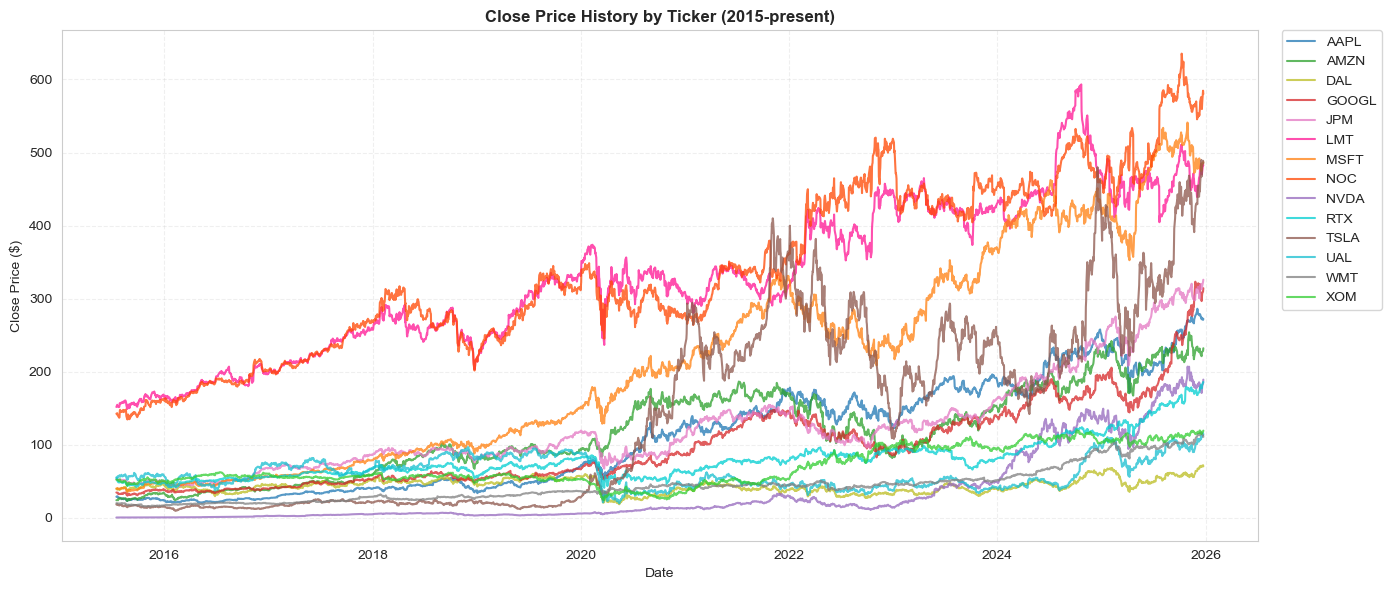

In [4]:
fig, ax = plt.subplots(figsize=(14, 6))

ticker_colors = {
    'AAPL': '#1f77b4', 'MSFT': '#ff7f0e', 'AMZN': '#2ca02c', 'GOOGL': '#d62728',
    'NVDA': '#9467bd', 'TSLA': '#8c564b', 'JPM': '#e377c2', 'WMT': '#7f7f7f',
    'DAL': '#bcbd22', 'UAL': '#17becf', 'LMT': '#ff1493', 'RTX': '#00ced1',
    'NOC': '#ff4500', 'XOM': '#32cd32'
}

for t in df['Ticker'].unique():
    subset = df[df['Ticker'] == t]
    ax.plot(subset['Date'], subset['Close'], alpha=0.75, label=t, 
            linewidth=1.5, color=ticker_colors.get(t, 'black'))

ax.set_title("Close Price History by Ticker (2015-present)", fontweight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("Close Price ($)")
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=True)
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### Returns, Volatility, and VIX

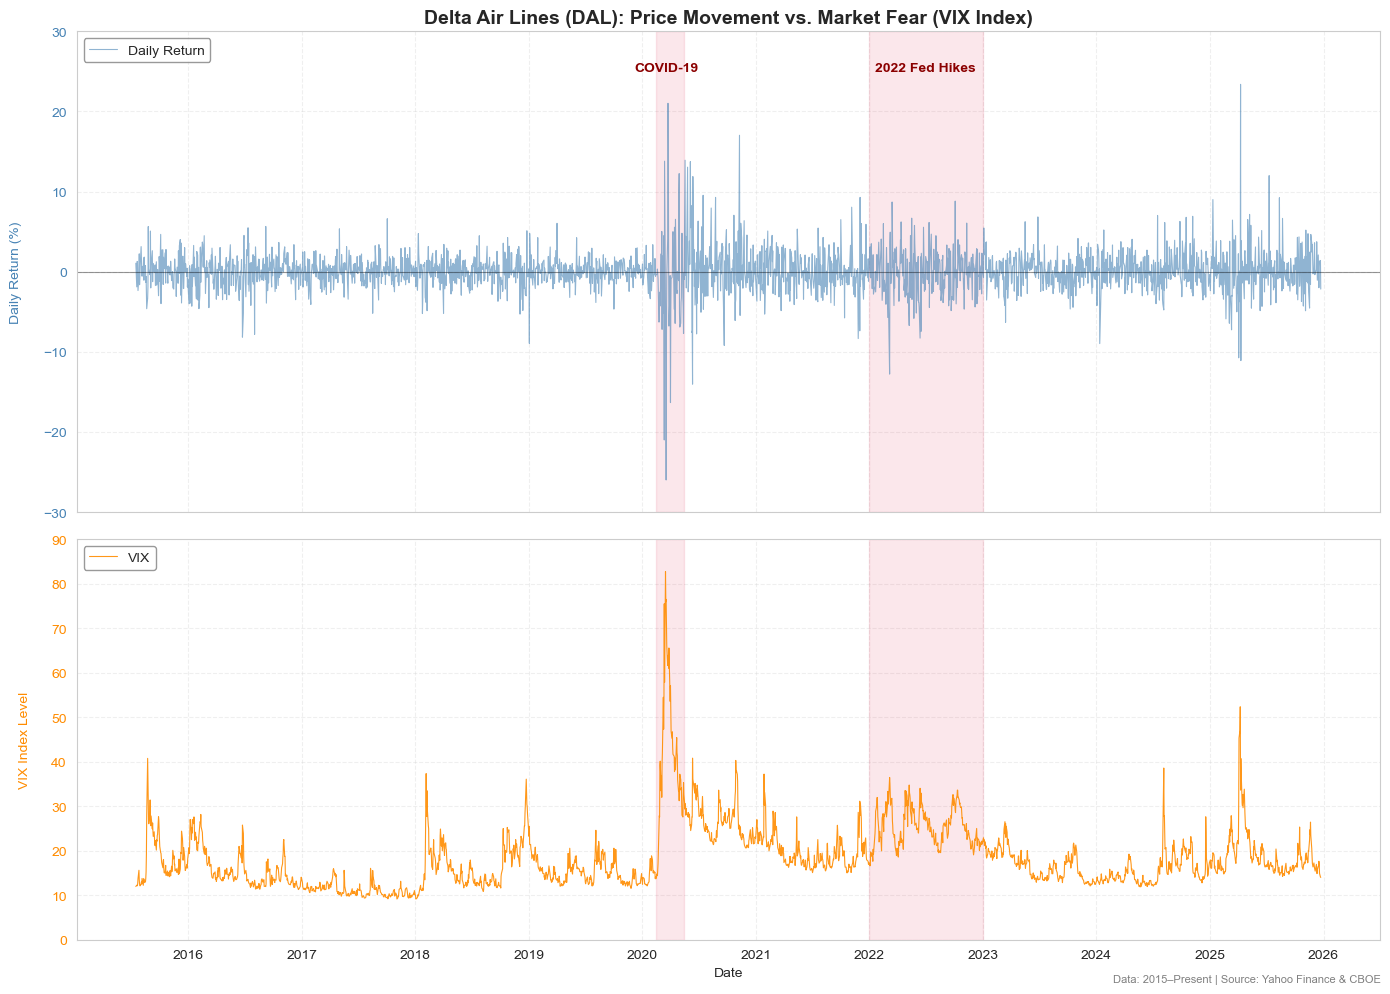

In [33]:
import matplotlib.dates as mdates

sample = df[df['Ticker'] == 'DAL']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                                gridspec_kw={'height_ratios': [1.2, 1]})
plt.subplots_adjust(hspace=0.02)

# Scale returns to percentages
returns_pct = sample['Return'] * 100

# Top plot: Daily returns
ax1.plot(sample['Date'], returns_pct, color='steelblue', alpha=0.6,
         linewidth=0.8, label='Daily Return')
ax1.axhline(0, color='black', linewidth=0.8, alpha=0.4)

# Danger zone: COVID-19
ax1.axvspan(pd.to_datetime('2020-02-15'), pd.to_datetime('2020-05-15'),
            color='crimson', alpha=0.1)
ax2.axvspan(pd.to_datetime('2020-02-15'), pd.to_datetime('2020-05-15'),
            color='crimson', alpha=0.1)
ax1.text(pd.to_datetime('2020-03-20'), 25, 'COVID-19',
         fontsize=10, color='darkred', ha='center', fontweight='bold')

# Danger zone: 2022 Fed Tightening
ax1.axvspan(pd.to_datetime('2022-01-01'), pd.to_datetime('2022-12-31'),
            color='crimson', alpha=0.1)
ax2.axvspan(pd.to_datetime('2022-01-01'), pd.to_datetime('2022-12-31'),
            color='crimson', alpha=0.1)
ax1.text(pd.to_datetime('2022-07-01'), 25, '2022 Fed Hikes',
         fontsize=10, color='darkred', ha='center', fontweight='bold')

# Top plot configuration
ax1.set_ylim(-30, 30)
ax1.set_ylabel("Daily Return (%)", color='steelblue', labelpad=15)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_title("Delta Air Lines (DAL): Price Movement vs. Market Fear "
              "(VIX Index)",
              fontweight='bold', fontsize=14)
ax1.legend(loc='upper left', frameon=True, facecolor='white',
           edgecolor='gray')

# Bottom plot: VIX
ax2.plot(sample['Date'], sample['VIX'], color='darkorange', alpha=0.9,
         linewidth=0.8, label='VIX')

ax2.set_ylim(0, 90)
ax2.set_ylabel("VIX Index Level", color='darkorange', labelpad=15)
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(loc='upper left', frameon=True, facecolor='white',
           edgecolor='gray')

# Format x-axis dates to show only years
ax2.set_xlabel("Date")
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add source attribution at bottom right
fig.text(0.99, 0.01, 'Data: 2015–Present | Source: Yahoo Finance & CBOE',
         ha='right', va='bottom', fontsize=8, color='gray')

plt.tight_layout()
plt.show()

### Feature Distributions

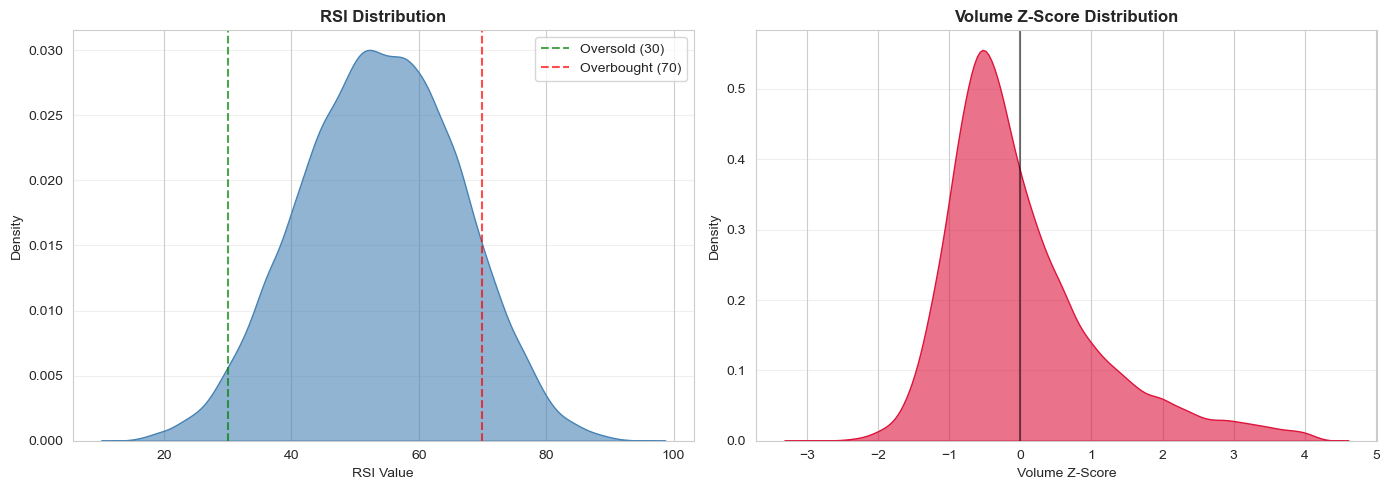

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.kdeplot(df['RSI'], ax=axes[0], fill=True, color='steelblue', alpha=0.6)
axes[0].axvline(30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
axes[0].axvline(70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
axes[0].set_title("RSI Distribution", fontweight='bold')
axes[0].set_xlabel("RSI Value")
axes[0].set_ylabel("Density")
axes[0].legend(frameon=True)
axes[0].grid(True, alpha=0.3, axis='y')

sns.kdeplot(df['Volume_Z'], ax=axes[1], fill=True, color='crimson', alpha=0.6)
axes[1].axvline(0, color='black', linestyle='-', alpha=0.5, linewidth=1.5)
axes[1].set_title("Volume Z-Score Distribution", fontweight='bold')
axes[1].set_xlabel("Volume Z-Score")
axes[1].set_ylabel("Density")
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Sector Statistics


Sector-wise Statistical Summary

          Avg_Return  Return_StdDev  Avg_Volatility  Pct_Up_Days  \
Sector                                                             
Airlines      0.0007         0.0291          0.0240       0.5118   
Defense       0.0006         0.0158          0.0133       0.5298   
Energy        0.0005         0.0176          0.0152       0.5129   
Finance       0.0008         0.0173          0.0145       0.5225   
Retail        0.0007         0.0137          0.0117       0.5354   
Tech          0.0015         0.0250          0.0212       0.5353   

          Pct_VolSpikes  
Sector                   
Airlines         0.2649  
Defense          0.2591  
Energy           0.2529  
Finance          0.2270  
Retail           0.1999  
Tech             0.2577  


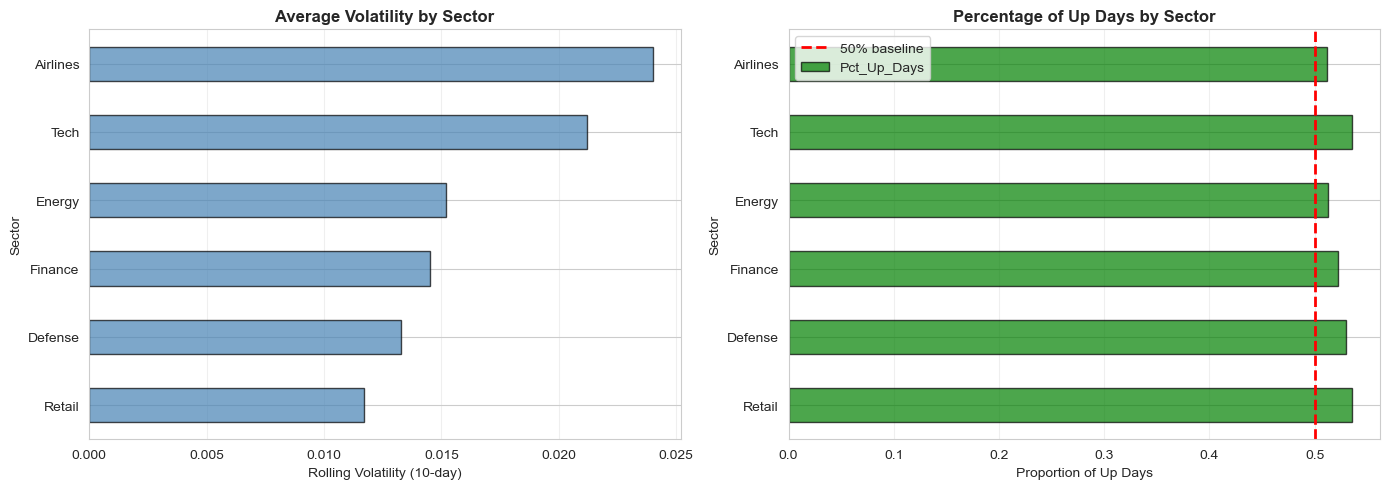

In [7]:
sectors = {
    'Tech': ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'NVDA', 'TSLA'],
    'Finance': ['JPM'],
    'Retail': ['WMT'],
    'Airlines': ['DAL', 'UAL'],
    'Defense': ['LMT', 'RTX', 'NOC'],
    'Energy': ['XOM']
}


def get_sector(ticker):
    for sector, tickers in sectors.items():
        if ticker in tickers:
            return sector
    return 'Other'


df['Sector'] = df['Ticker'].apply(get_sector)

sector_stats = df.groupby('Sector').agg({
    'Return': ['mean', 'std'],
    'RollingVol': 'mean',
    'Direction': 'mean',
    'VolSpike': 'mean'
}).round(4)

sector_stats.columns = ['Avg_Return', 'Return_StdDev', 'Avg_Volatility',
                        'Pct_Up_Days', 'Pct_VolSpikes']
print("\nSector-wise Statistical Summary\n")
print(sector_stats)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sector_stats['Avg_Volatility'].sort_values().plot(
    kind='barh', ax=ax1, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_title('Average Volatility by Sector', fontweight='bold')
ax1.set_xlabel('Rolling Volatility (10-day)')
ax1.grid(True, alpha=0.3, axis='x')

# Match sector ordering from left plot
sector_order = sector_stats.sort_values('Avg_Volatility').index
sector_stats.loc[sector_order, 'Pct_Up_Days'].plot(
    kind='barh', ax=ax2, color='green', alpha=0.7, edgecolor='black')
ax2.axvline(0.5, color='red', linestyle='--', linewidth=2,
            label='50% baseline')
ax2.set_title('Percentage of Up Days by Sector', fontweight='bold')
ax2.set_xlabel('Proportion of Up Days')
ax2.legend(frameon=True)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### Return Distribution

Return distributions are fat-tailed (excess kurtosis around 13.9), meaning extreme moves happen more often than a normal assumption would predict. This supports using time-based evaluation and models that stay stable in both calm and stressed periods, rather than optimizing for one quiet stretch of the market.

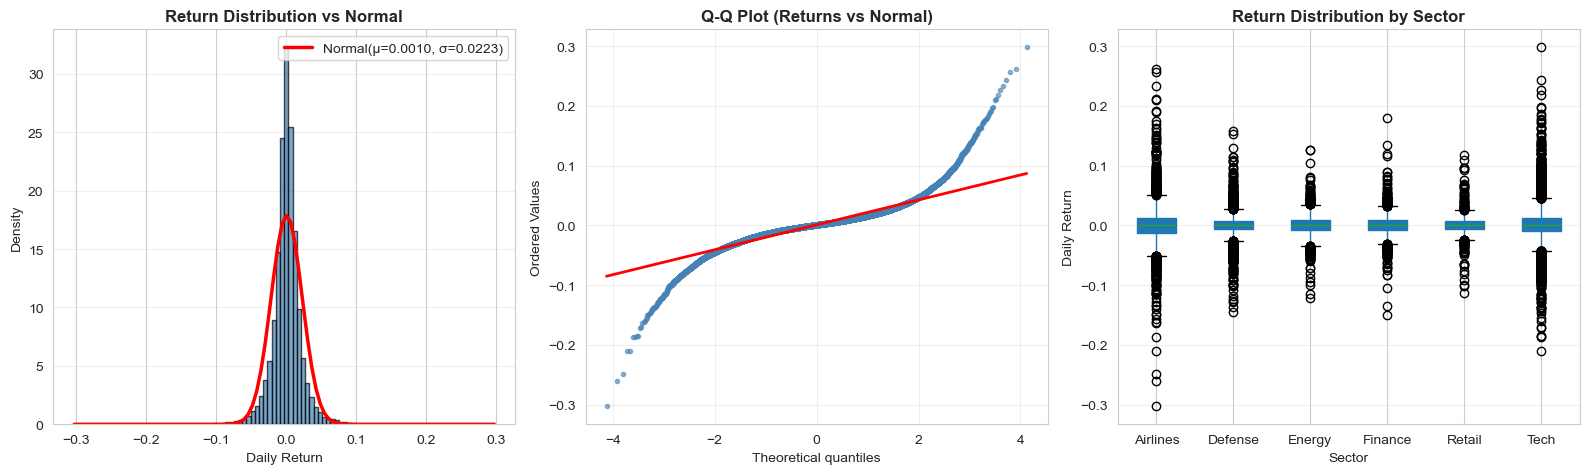

Skewness: 0.3457
Excess Kurtosis: 13.9166
Normality Test p-value: 0.0000e+00
Normal distribution hypothesis rejected at α=0.05


In [8]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

mu, sigma = df['Return'].mean(), df['Return'].std()
x = np.linspace(df['Return'].min(), df['Return'].max(), 100)

# Histogram with fitted normal curve
axes[0].hist(df['Return'], bins=100, density=True, alpha=0.7,
             color='steelblue', edgecolor='black')
axes[0].plot(x, stats.norm.pdf(x, mu, sigma), color='red', linewidth=2.5,
             label=f'Normal(μ={mu:.4f}, σ={sigma:.4f})')
axes[0].set_title('Return Distribution vs Normal', fontweight='bold')
axes[0].set_xlabel('Daily Return')
axes[0].set_ylabel('Density')
axes[0].legend(frameon=True)
axes[0].grid(True, alpha=0.3, axis='y')

# Q-Q plot to check normality
stats.probplot(df['Return'], dist="norm", plot=axes[1])
axes[1].get_lines()[0].set_color('steelblue')
axes[1].get_lines()[0].set_markersize(3)
axes[1].get_lines()[0].set_alpha(0.6)
axes[1].get_lines()[1].set_color('red')
axes[1].get_lines()[1].set_linewidth(2)
axes[1].set_title('Q-Q Plot (Returns vs Normal)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Box plot by sector
sector_order = sector_stats.sort_values('Avg_Volatility').index.tolist()
bp = df.boxplot(column='Return', by='Sector', ax=axes[2],
                patch_artist=True, positions=range(len(sector_order)))
for patch in bp.artists:
    patch.set_facecolor('steelblue')
    patch.set_alpha(0.6)
axes[2].set_title('Return Distribution by Sector', fontweight='bold')
axes[2].set_xlabel('Sector')
axes[2].set_ylabel('Daily Return')
axes[2].grid(True, alpha=0.3, axis='y')
plt.suptitle('')

plt.tight_layout()
plt.show()

skewness = stats.skew(df['Return'])
kurtosis = stats.kurtosis(df['Return'])
_, normality_p = stats.normaltest(df['Return'])

print(f"Skewness: {skewness:.4f}")
print(f"Excess Kurtosis: {kurtosis:.4f}")
print(f"Normality Test p-value: {normality_p:.4e}")
reject_text = 'rejected' if normality_p < 0.05 else 'not rejected'
print(f"Normal distribution hypothesis {reject_text} at α=0.05")

### Feature Correlations

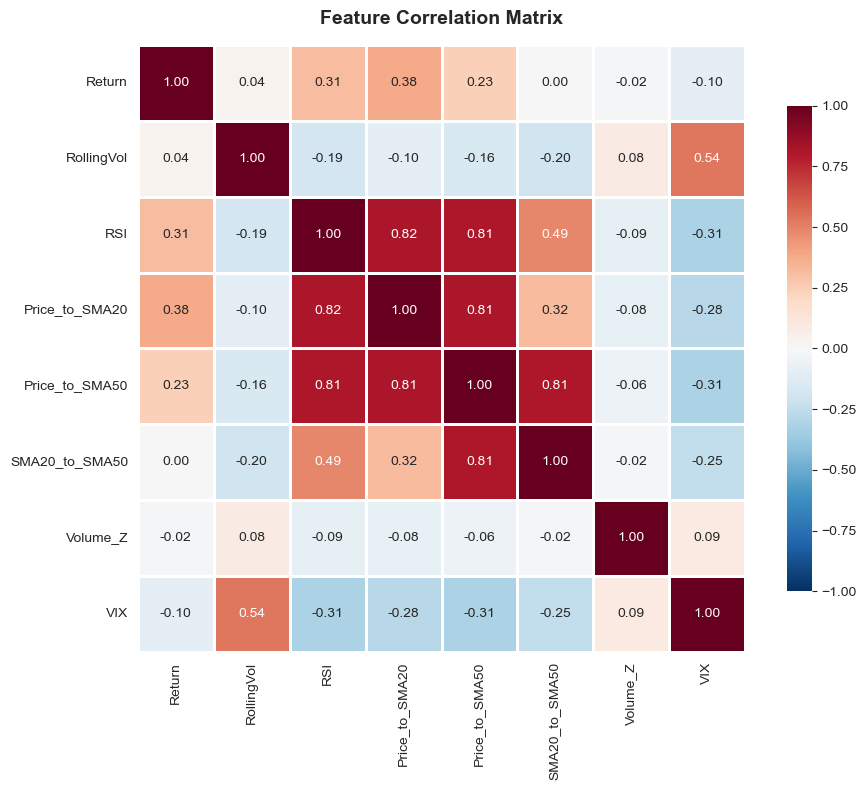

In [9]:
numeric_cols = ['Return','RollingVol','RSI','Price_to_SMA20','Price_to_SMA50','SMA20_to_SMA50','Volume_Z','VIX']
corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax,
            vmin=-1, vmax=1)
ax.set_title("Feature Correlation Matrix", fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

### Target Balance

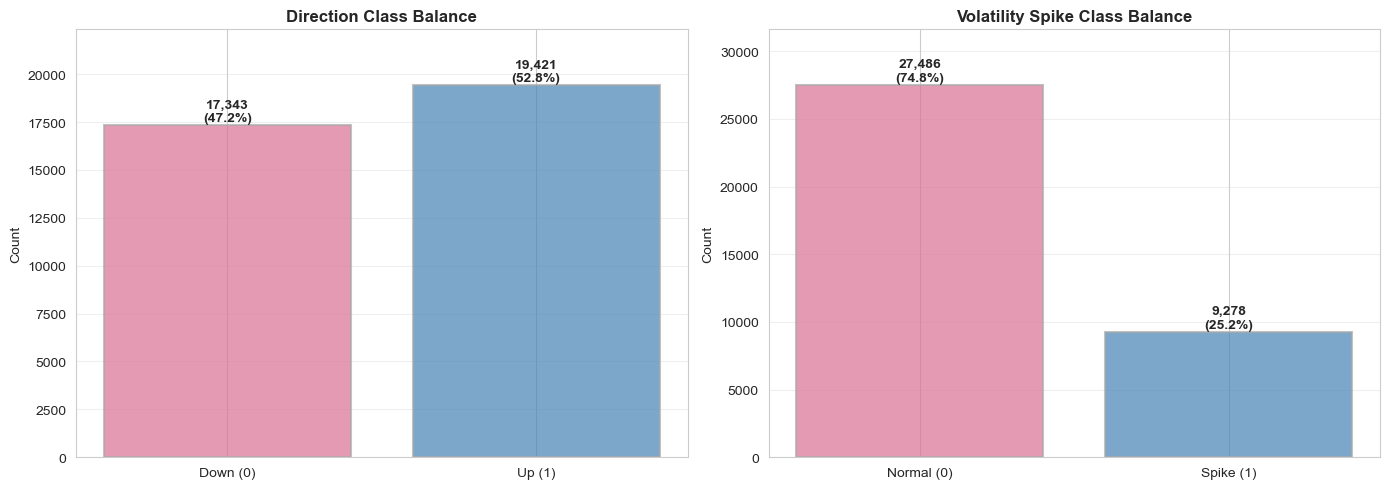

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

dir_counts = df['Direction'].value_counts().sort_index()
axes[0].bar(['Down (0)', 'Up (1)'], dir_counts.values,
            color=['palevioletred', 'steelblue'], alpha=0.7,
            edgecolor='darkgrey', linewidth=1.5)
axes[0].set_title('Direction Class Balance', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, max(dir_counts.values) * 1.15)
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(dir_counts.values):
    axes[0].text(i, v + 200, f'{v:,}\n({v/len(df)*100:.1f}%)',
                 ha='center', fontweight='bold')

vol_counts = df['VolSpike'].value_counts().sort_index()
axes[1].bar(['Normal (0)', 'Spike (1)'], vol_counts.values,
            color=['palevioletred', 'steelblue'], alpha=0.7,
            edgecolor='darkgrey', linewidth=1.5)
axes[1].set_title('Volatility Spike Class Balance', fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_ylim(0, max(vol_counts.values) * 1.15)
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(vol_counts.values):
    axes[1].text(i, v + 300, f'{v:,}\n({v/len(df)*100:.1f}%)',
                 ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

RSI is a weak standalone signal for next-day direction. Using classic 70/30 thresholds yields a hit rate around 53 percent, only slightly above the always-Up baseline. Any meaningful lift is more likely to come from feature interactions than from single-indicator rules.

        RSI_Zone  Pct_Up_Next_Day  Sample_Count
 Neutral (30-70)         0.527778         32148
Overbought (>70)         0.530365          3639
  Oversold (<30)         0.536336           977


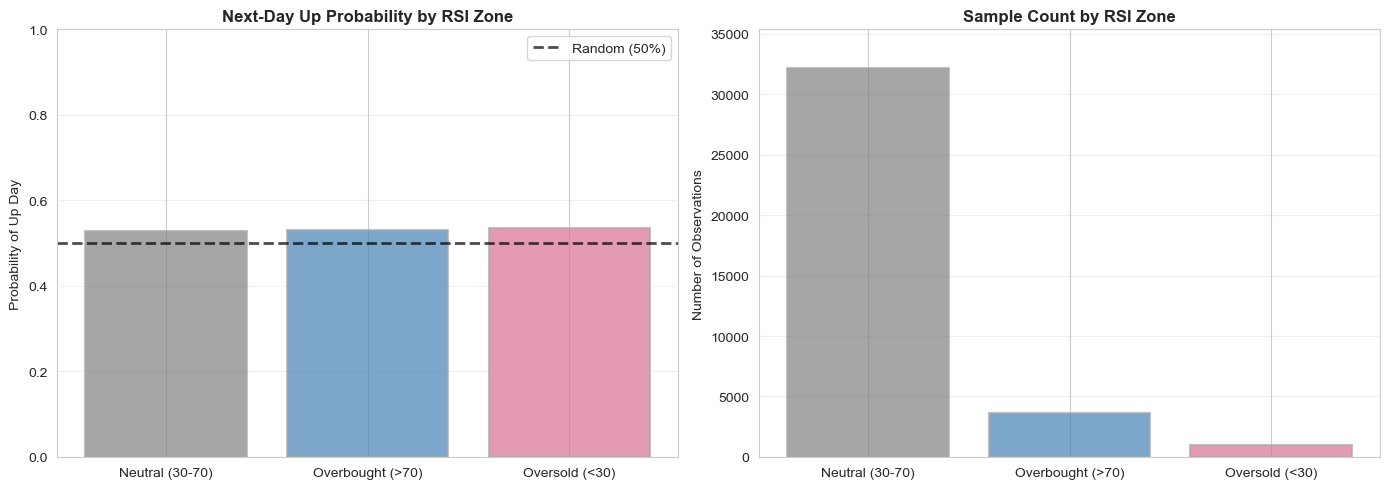

In [11]:
def categorize_rsi(rsi):
    if rsi < 30:
        return 'Oversold (<30)'
    elif rsi > 70:
        return 'Overbought (>70)'
    else:
        return 'Neutral (30-70)'


df['RSI_Zone'] = df['RSI'].apply(categorize_rsi)

# Check next-day up probability by RSI zone
rsi_signal = df.groupby('RSI_Zone')['Direction'].agg(
    ['mean', 'count']).reset_index()
rsi_signal.columns = ['RSI_Zone', 'Pct_Up_Next_Day', 'Sample_Count']
rsi_signal = rsi_signal.sort_values('Pct_Up_Next_Day')

print(rsi_signal.to_string(index=False))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

zone_colors = ['grey', 'steelblue', 'palevioletred']
ax1.bar(range(len(rsi_signal)), rsi_signal['Pct_Up_Next_Day'],
        color=zone_colors, alpha=0.7, edgecolor='darkgrey', linewidth=1.5)
ax1.set_xticks(range(len(rsi_signal)))
ax1.set_xticklabels(rsi_signal['RSI_Zone'], rotation=0)
ax1.axhline(0.5, color='black', linestyle='--', linewidth=2, alpha=0.7,
            label='Random (50%)')
ax1.set_title('Next-Day Up Probability by RSI Zone', fontweight='bold')
ax1.set_ylabel('Probability of Up Day')
ax1.set_ylim(0, 1)
ax1.legend(frameon=True)
ax1.grid(True, alpha=0.3, axis='y')

ax2.bar(range(len(rsi_signal)), rsi_signal['Sample_Count'],
        color=zone_colors, alpha=0.7, edgecolor='darkgrey', linewidth=1.5)
ax2.set_xticks(range(len(rsi_signal)))
ax2.set_xticklabels(rsi_signal['RSI_Zone'], rotation=0)
ax2.set_title('Sample Count by RSI Zone', fontweight='bold')
ax2.set_ylabel('Number of Observations')
ax2.set_ylim(0, max(rsi_signal['Sample_Count']) * 1.1)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### COVID Volatility Spike

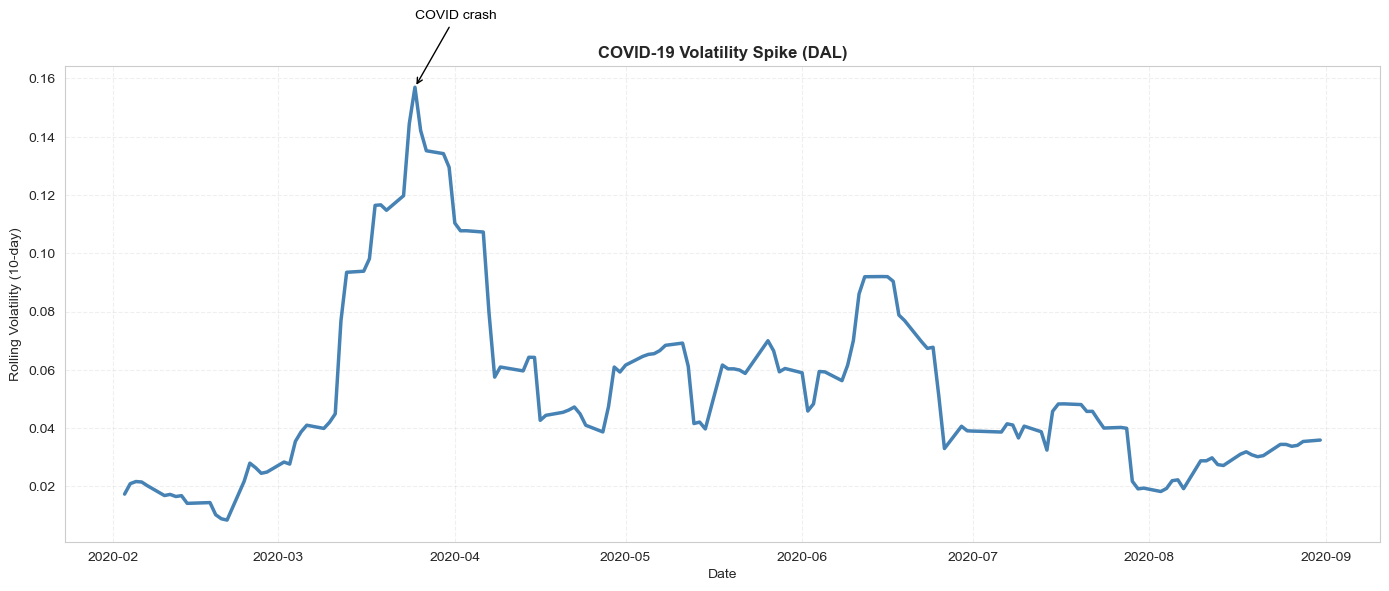

In [12]:
covid = df[(df['Date'] > '2020-02-01') & (df['Date'] < '2020-09-01') & (df['Ticker']=='DAL')]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(covid['Date'], covid['RollingVol'], color='steelblue', linewidth=2.5)

if not covid.empty:
    peak = covid.loc[covid['RollingVol'].idxmax()]
    ax.annotate(
        "COVID crash",
        xy=(peak['Date'], peak['RollingVol']),
        xytext=(peak['Date'], peak['RollingVol'] * 1.15),
        arrowprops=dict(arrowstyle='->', color='black', lw=1),
        fontsize=10,
        color='black'
    )

ax.set_title("COVID-19 Volatility Spike (DAL)", fontweight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("Rolling Volatility (10-day)")
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### Volatility Market Environments

                        Avg_Return  Return_StdDev  Avg_RollingVol  \
Vol_Environment                                                     
Low Vol (VIX<15)            0.0023         0.0157          0.0134   
Medium Vol (15≤VIX<25)      0.0011         0.0206          0.0184   
High Vol (VIX≥25)          -0.0027         0.0369          0.0302   

                        Pct_Up_Days  Pct_VolSpikes  Sample_Count  
Vol_Environment                                                   
Low Vol (VIX<15)             0.5324         0.0975         13314  
Medium Vol (15≤VIX<25)       0.5285         0.2467         18172  
High Vol (VIX≥25)            0.5171         0.6626          5278  


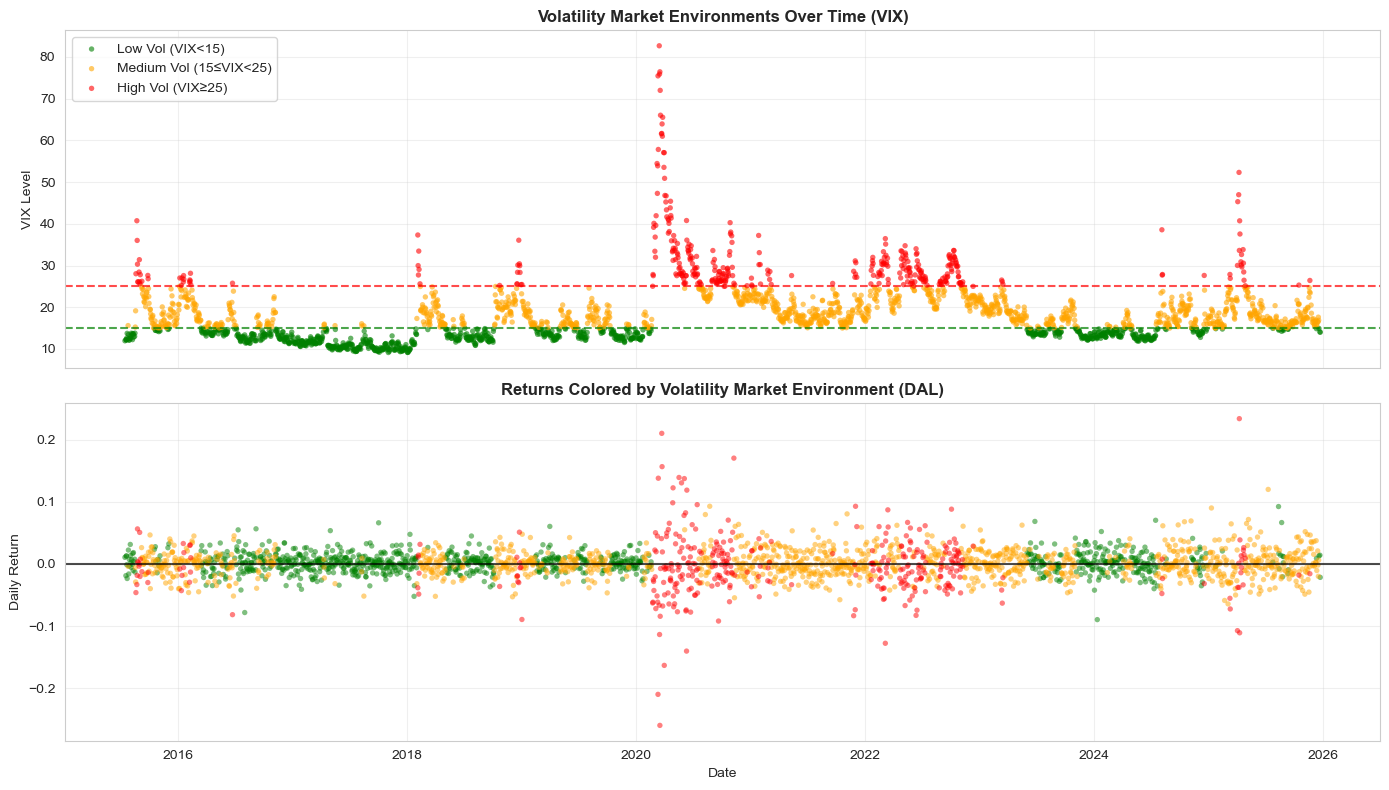

In [13]:
def categorize_vix(vix):
    if vix < 15:
        return 'Low Vol (VIX<15)'
    elif vix < 25:
        return 'Medium Vol (15≤VIX<25)'
    else:
        return 'High Vol (VIX≥25)'


df['Vol_Environment'] = df['VIX'].apply(categorize_vix)

environment_stats = df.groupby('Vol_Environment').agg({
    'Return': ['mean', 'std'],
    'RollingVol': 'mean',
    'Direction': 'mean',
    'VolSpike': 'mean',
    'VIX': 'count'
}).round(4)

environment_stats.columns = ['Avg_Return', 'Return_StdDev', 'Avg_RollingVol',
                              'Pct_Up_Days', 'Pct_VolSpikes', 'Sample_Count']
environment_stats = environment_stats.sort_values('Avg_RollingVol')

print(environment_stats)

dal_environment = df[df['Ticker'] == 'DAL'].copy()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

colors_map = {
    'Low Vol (VIX<15)': 'green',
    'Medium Vol (15≤VIX<25)': 'orange',
    'High Vol (VIX≥25)': 'red'
}

# Plot VIX levels colored by environment
for environment in ['Low Vol (VIX<15)', 'Medium Vol (15≤VIX<25)',
                    'High Vol (VIX≥25)']:
    subset = dal_environment[dal_environment['Vol_Environment'] == environment]
    if len(subset) > 0:
        ax1.scatter(subset['Date'], subset['VIX'], c=colors_map[environment],
                    label=environment, alpha=0.6, s=15, edgecolors='none')

ax1.axhline(15, color='green', linestyle='--', alpha=0.7, linewidth=1.5)
ax1.axhline(25, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax1.set_ylabel('VIX Level')
ax1.set_title('Volatility Market Environments Over Time (VIX)',
              fontweight='bold')
ax1.legend(loc='upper left', frameon=True)
ax1.grid(True, alpha=0.3)

# Plot returns colored by environment
for environment in ['Low Vol (VIX<15)', 'Medium Vol (15≤VIX<25)',
                    'High Vol (VIX≥25)']:
    subset = dal_environment[dal_environment['Vol_Environment'] == environment]
    if len(subset) > 0:
        ax2.scatter(subset['Date'], subset['Return'],
                    c=colors_map[environment],
                    alpha=0.5, s=15, edgecolors='none')

ax2.axhline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
ax2.set_xlabel('Date')
ax2.set_ylabel('Daily Return')
ax2.set_title('Returns Colored by Volatility Market Environment (DAL)',
              fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2022 Federal Tightening

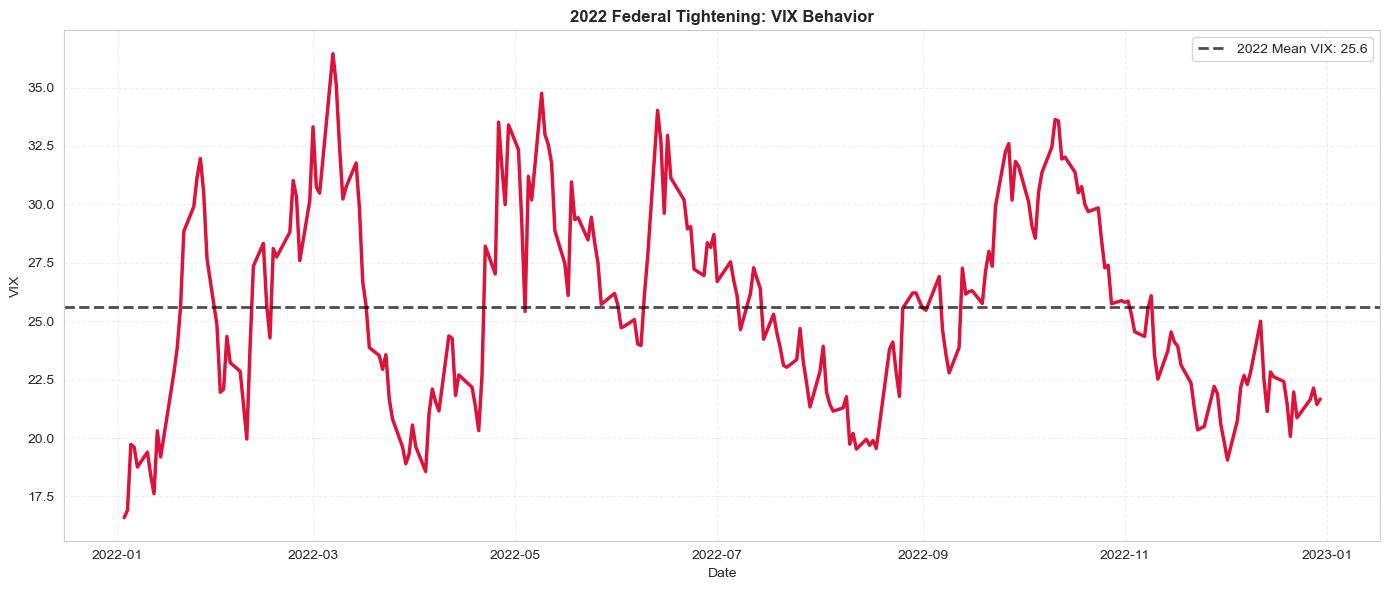

In [ ]:
taper = df[(df['Date'] > '2022-01-01') & (df['Date'] < '2022-12-31') & (df['Ticker']=='DAL')]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(taper['Date'], taper['VIX'], color='crimson', linewidth=2.5)
ax.axhline(taper['VIX'].mean(), color='black', linestyle='--', linewidth=2, 
          label=f"2022 Mean VIX: {taper['VIX'].mean():.1f}", alpha=0.7)
ax.set_title("2022 Federal Tightening: VIX Behavior", fontweight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("VIX")
ax.legend(frameon=True)
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### Key Takeaways and Modeling Strategy

EDA revealed:
- Volatility clusters and is environment-like, with sustained high-volatility periods during major market stress (not just isolated one-day events). Models should be stress-tested on these windows rather than evaluated only on calm periods.
- Returns are heavy-tailed and noisy, so performance should be judged by stability over time and against simple baselines, not by a single best-case score.
- VolSpike is meaningfully imbalanced, so spike detection needs metrics that reflect rare-event performance (precision/recall and PR-AUC), plus careful threshold selection.

Future modeling decisions:
- Use time-based evaluation (walk-forward or expanding-window) and report results across multiple windows, including crisis periods as explicit stress tests.
- Start with simple baselines and regularized models, then move to nonlinear models (tree ensembles) to capture feature interactions if they add consistent lift.
- Handle spike imbalance with class weights, calibrated probabilities, and threshold tuning. Avoid any resampling method unless it is applied strictly within each training split.

Next steps:
- Train baseline models for Direction and VolSpike using walk-forward splits.
- Inspect feature importance and error patterns across time windows.
- Validate robustness during high-volatility market environments.